<a href="https://colab.research.google.com/github/qiterri/ADALL_github/blob/main/09Feb26_ADALL_LastLab_SHAP_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADALL Last Lab (1 session): SHAP for a Regression Target (with Persona + What-If)

## What you will do today
By the end of this lab, you should be able to:
- Explain what a SHAP value means for **regression** (baseline + contributions, same unit as target).
- Produce **global** and **local** SHAP plots (summary, dependence, waterfall).
- Translate model explanations into **persona-based actions** (business decision style).
- Run simple **what-if** checks to test model sensitivity (without claiming causality).

<hr>

<font color='red'><b>Note</b>: SHAP explains how <i>your model</i> behaves on your dataset. It does not prove real-world cause and effect.</font>


In [ ]:
# ==============================
# 0) Setup (Colab-friendly)
# ==============================
# If you are running in Google Colab, you may need these installs.
# Tip: If installs are slow, run once, then restart runtime.
#!pip -q install -U shap xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
import shap

np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

# Global defaults for the whole notebook
mpl.rcParams["axes.formatter.useoffset"] = False
mpl.rcParams["axes.formatter.limits"] = (-100, 100)   # effectively stops scientific notation like 1e6
mpl.rcParams["axes.formatter.use_mathtext"] = False



## 1) Load dataset (regression target)

This notebook is written to work with the **Vehicle Sales** dataset used earlier in ADALL (`sellingprice` as target).

If you are using a different regression dataset, update:
- `TARGET_COL`
- any columns you want to drop

<font color='red'><b>Note</b>: If your dataset is already clean, you can still score well by proving that with checks rather than inventing fixes.</font>


In [ ]:
import kagglehub
path = kagglehub.dataset_download("harlfoxem/housesalesprediction")
df = pd.read_csv(f"{path}/kc_house_data.csv")
df


100%|██████████| 780k/780k [00:00<00:00, 1.66MB/s]

Extracting files...


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [ ]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
target_col = "price"
feature_cols = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'waterfront',
    'view',
    'condition',
    'grade',
    'sqft_above',
    'sqft_basement',
    'yr_built',
    'yr_renovated'
]
df = df[feature_cols + [target_col]].copy()
df = df.dropna()
df = df.sample(5000, random_state=42)

## 2) Quick dataset profile (text, no charts)

You are building a short “dataset profile” in your head before explaining a model:
- columns and dtypes
- missing values
- target distribution (basic stats only)

<font color='red'><b>Note</b>: Today is not a data cleaning lab. Keep it minimal and justify choices.</font>


In [ ]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)


=== DTYPES ===
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
price            float64

=== NUMERIC DESCRIBE ===
          bedrooms    bathrooms   sqft_living      sqft_lot       floors  waterfront         view    condition        grade   sqft_above  sqft_basement     yr_built  yr_renovated         price
count  5000.000000  5000.000000   5000.000000  5.000000e+03  5000.000000  5000.00000  5000.000000  5000.000000  5000.000000  5000.000000    5000.000000  5000.000000   5000.000000  5.000000e+03
mean      3.379200     2.116800   2097.277800  1.605632e+04     1.477800     0.00900     0.236400     3.414400     7.666200  1794.751800     302.526000  1970.507000     91.409000  5.465468e+05
std       0.924975     0.78471

In [ ]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [ ]:
# response = client.responses.create(
#     model="gpt-5-mini",
#     instructions="""
# You are an expert data scientist with extensive knowledge of tree-based models.
# Always justify recommendations using reasoning trace based ONLY on the dataset profile.
# """,
#     input=f"""
# Dataset info: {payload_text}\n
# Questions:\n
# 1. Based on the dataset profile, what data quality issues should be resolved before modelling?
# Provide a priority list and justify each item. \n
# 2. Which columns appear redundant, correlated, or likely to cause leakage?
# Explain why each is problematic. \n
# Next: Provide a python script to handle the identified issues.
# Define one helper function for each issue.
# Then define a wrapper function that calls these helper with true false option as user choice
# Provide a single line of code to run the overall wrapper function.
# Do not encode categorical columns or model first.
# """)

# print(response.output_text)


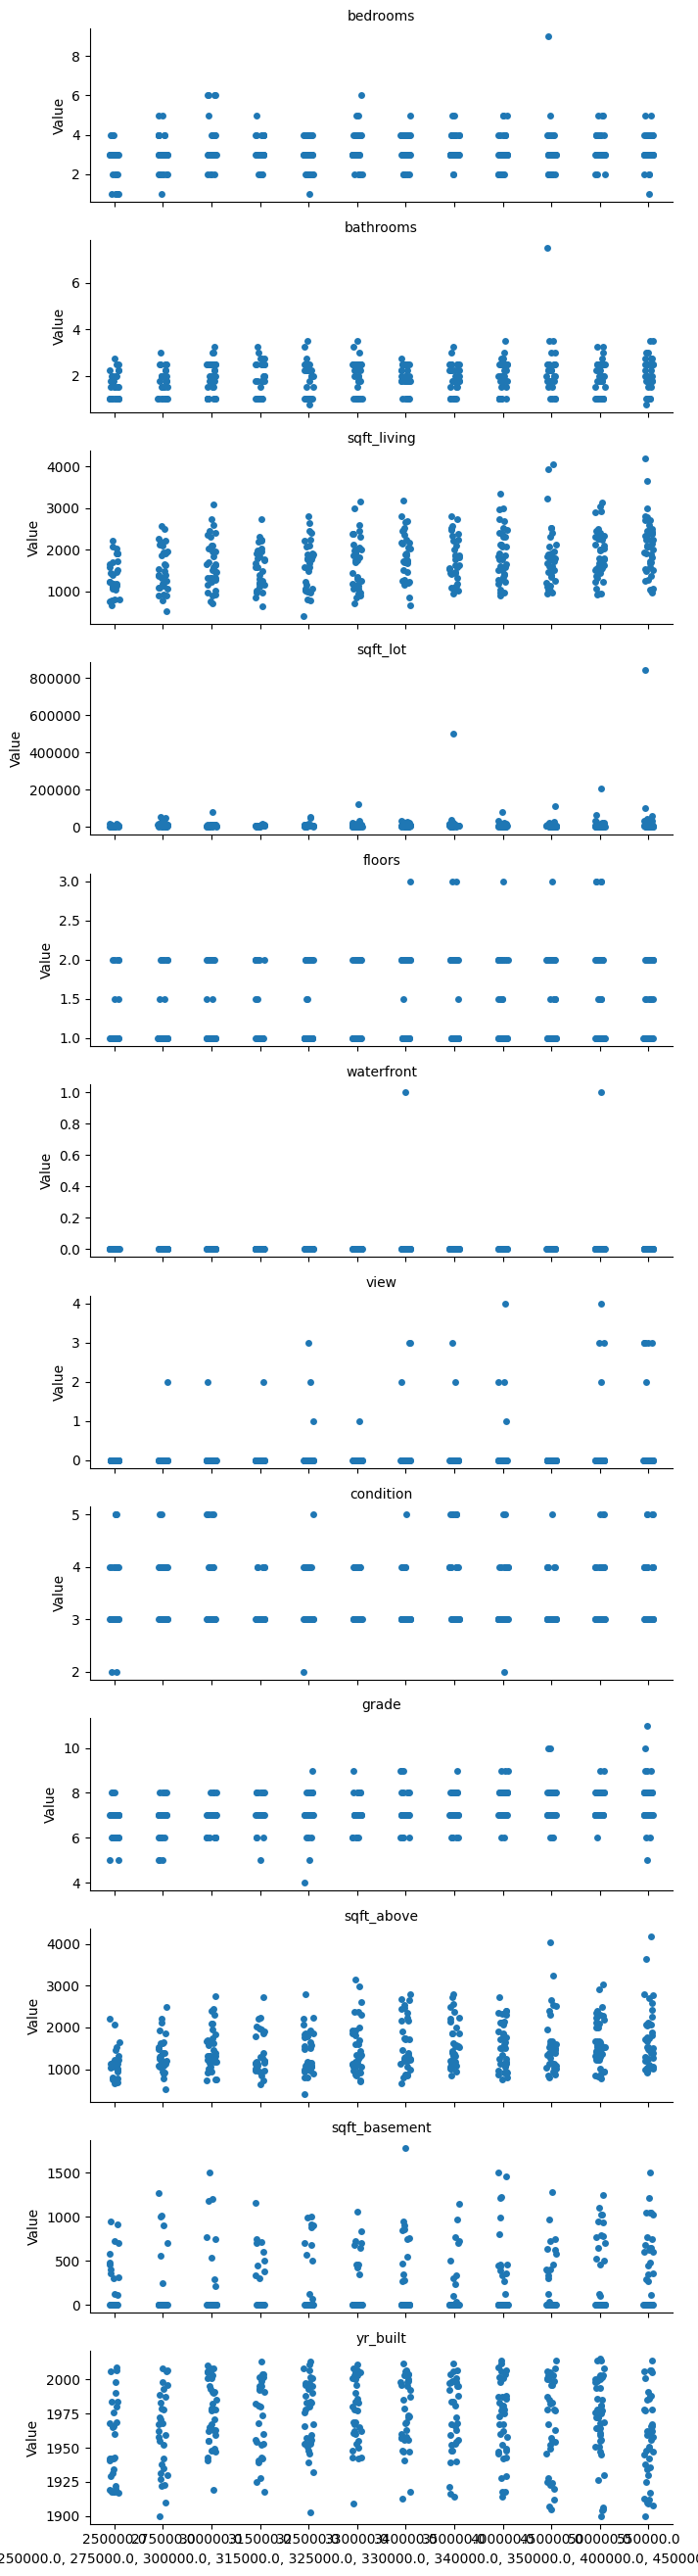

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def jitter_numeric_fast(
    df: pd.DataFrame,
    target_col: str,
    num_cols: list[str] | None = None,
    order: list | None = None,
    max_features: int = 12,
    sample: int | None = 8000,
    max_classes: int = 12,
    class_order: str = "auto",  # "auto" | "sorted" | "freq"
    dropna_target: bool = True
):
    """
    Fast jitter plot for numeric features vs a discrete target.

    x = target classes
    y = numeric feature values (one facet per feature)

    Works for:
    - integer-coded targets (e.g. 0,1,2,3 or 1..5)
    - categorical/string targets (e.g. 'Low','Med','High')
    """

    if target_col not in df.columns:
        raise KeyError(f"target_col='{target_col}' not found in df")

    d = df.copy()

    # Drop missing target (usually safest)
    if dropna_target:
        d = d.dropna(subset=[target_col])

    # Auto-detect class order if not provided
    if order is None:
        y = d[target_col]

        # If numeric-like (includes integer-coded), prefer sorted unique
        if pd.api.types.is_numeric_dtype(y):
            uniq = pd.unique(y)
            # remove NaN if present
            uniq = [v for v in uniq if pd.notna(v)]
            order = sorted(uniq)

            # If too many unique values, keep most frequent ones
            if len(order) > max_classes:
                top = y.value_counts().head(max_classes).index.tolist()
                order = sorted(top)

        else:
            # For non-numeric target, default to most frequent classes
            vc = y.astype("object").value_counts(dropna=False)
            order = vc.head(max_classes).index.tolist()

            if class_order == "sorted":
                order = sorted(order)
            elif class_order == "freq":
                order = order  # already by frequency
            else:
                # auto: if categories have natural order (pandas Categorical ordered), preserve it
                if pd.api.types.is_categorical_dtype(y) and y.cat.ordered:
                    order = list(y.cat.categories)
                    if len(order) > max_classes:
                        order = vc.head(max_classes).index.tolist()

    # Filter df to those classes
    d = d[d[target_col].isin(order)].copy()

    # Sample for speed
    if sample is not None and len(d) > sample:
        d = d.sample(sample, random_state=42)

    # Auto-detect numeric feature columns
    if num_cols is None:
        num_cols = d.select_dtypes(include="number").columns.tolist()
        num_cols = [c for c in num_cols if c != target_col]

    # Keep only existing columns
    num_cols = [c for c in num_cols if c in d.columns]

    if len(num_cols) == 0:
        raise ValueError("No numeric columns found to plot (after excluding target_col).")

    num_cols = num_cols[:max_features]

    # Long form for faceting
    long_df = d.melt(
        id_vars=[target_col],
        value_vars=num_cols,
        var_name="feature",
        value_name="value"
    ).dropna(subset=["value"])

    # Make target explicitly ordered categorical so seaborn respects the x order
    long_df[target_col] = pd.Categorical(long_df[target_col], categories=order, ordered=True)

    g = sns.catplot(
        data=long_df,
        x=target_col,
        y="value",
        row="feature",
        kind="strip",
        order=order,
        jitter=True,
        height=2.2,
        aspect=3.2,
        sharey=False
    )

    g.set_axis_labels(f"{target_col} (classes: {order})", "Value")
    g.set_titles("{row_name}")
    plt.tight_layout()
    plt.show()

    return order, num_cols


# Example:
order_used, num_cols_used = jitter_numeric_fast(df, target_col=target_col, sample=15000)
# print("Order used:", order_used)
# print("Numeric columns plotted:", num_cols_used)


## 3) Train a strong-but-simple regression model (tree-based)

Why tree-based for SHAP today?
- Tree SHAP is fast and widely used for tree models.
- Regression SHAP values are in the **same unit** as the target (e.g., dollars).

We will:
- split train/test
- build a preprocessing pipeline (impute + one-hot)
- fit an XGBoost regressor
- evaluate with MAE

<font color='red'><b>Note</b>: You are not competing for best score. You are practising explanation and judgement.</font>


In [ ]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
# 2) Split features/target
X = df.drop(columns=[target_col])
y = df[target_col].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# ------------------------------------------------------------
# PREPROCESSOR
# Make sure preprocessing is inside a Pipeline to avoid leakage.
# ------------------------------------------------------------
# Identify columns by dtype
num_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# -------------------------------------------
# 1. Create pipelines for both models
# -------------------------------------------
pipe_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        random_state=42))
])

# -------------------------------------------
# 2. Define parameter grids
# Keep them small for speed and simplicity
# -------------------------------------------

param_grid_xgb = {
    "regressor__n_estimators": [50, 200],
  'regressor__max_depth':[2,4,6],
  'regressor__eval_metric':['rmse', 'mae']
}

# -------------------------------------------
# 3. Create GridSearchCV objects
# -------------------------------------------

gs_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

# -------------------------------------------
# 4. Fit both models
# (Students can run one at a time if needed)
# -------------------------------------------e

gs_xgb.fit(X_train, y_train)
print("XGBoost grid search complete.")

# -------------------------------------------
# 5. Evaluate on test set
# -------------------------------------------

from sklearn.metrics import mean_absolute_error
xgb_pred = gs_xgb.best_estimator_.predict(X_test)

print("\nMAE (XGBoost):", mean_absolute_error(y_test, xgb_pred))
print("Best XGB Params:", gs_xgb.best_params_)


Fitting 10 folds for each of 12 candidates, totalling 120 fits
XGBoost grid search complete.

MAE (XGBoost): 129044.068890625
Best XGB Params: {'regressor__eval_metric': 'rmse', 'regressor__max_depth': 2, 'regressor__n_estimators': 50}


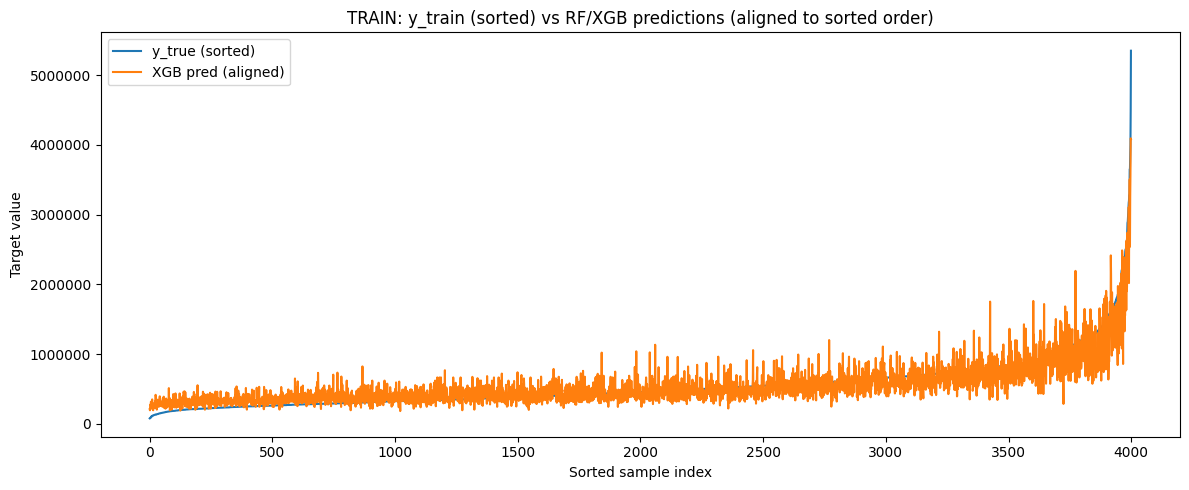

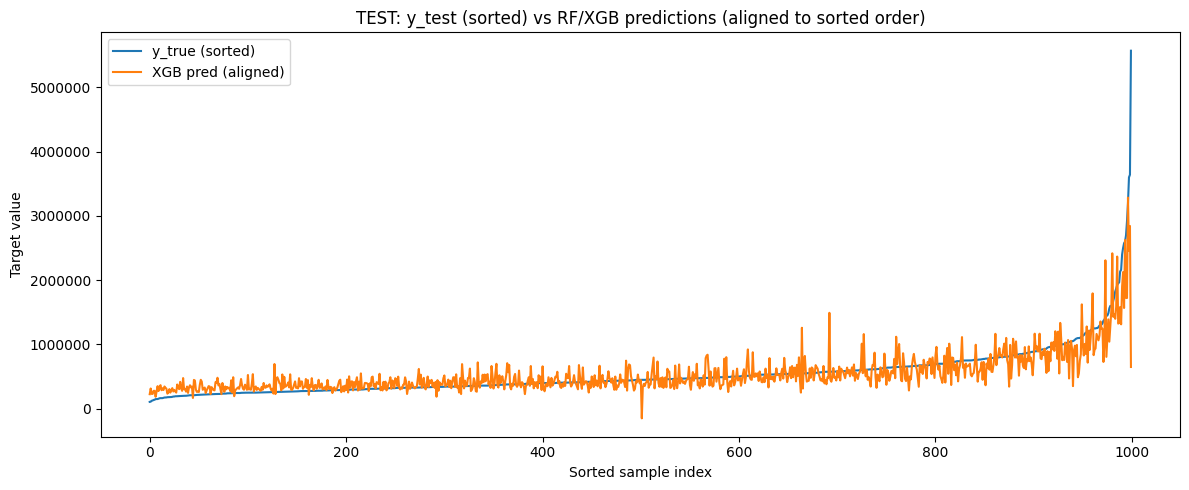

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Helper: plot y_true sorted, with y_pred aligned to same order
# ------------------------------------------------------------
def plot_sorted_true_vs_pred(y_true, y_pred_dict, title, xlabel="Sorted sample index"):
    """
    y_true: 1D array-like
    y_pred_dict: dict of {label: y_pred (1D array-like)}
    """
    y_true = np.asarray(y_true).ravel()

    order = np.argsort(y_true)          # indices that would sort y_true
    y_true_sorted = y_true[order]

    plt.figure(figsize=(12, 5))
    plt.plot(y_true_sorted, label="y_true (sorted)")

    for label, y_pred in y_pred_dict.items():
        y_pred = np.asarray(y_pred).ravel()
        plt.plot(y_pred[order], label=f"{label} pred (aligned)")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Target value")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 1) Get predictions for TRAIN and TEST for both models
# ------------------------------------------------------------
xgb_train_pred = gs_xgb.best_estimator_.predict(X_train)

xgb_test_pred  = gs_xgb.best_estimator_.predict(X_test)


# ------------------------------------------------------------
# 2) Plot TRAIN: y_train sorted + aligned preds
# ------------------------------------------------------------
plot_sorted_true_vs_pred(
    y_true=y_train,
    y_pred_dict={
        "XGB": xgb_train_pred
    },
    title="TRAIN: y_train (sorted) vs RF/XGB predictions (aligned to sorted order)"
)


# ------------------------------------------------------------
# 3) Plot TEST: y_test sorted + aligned preds
# ------------------------------------------------------------
plot_sorted_true_vs_pred(
    y_true=y_test,
    y_pred_dict={
        "XGB": xgb_test_pred
    },
    title="TEST: y_test (sorted) vs RF/XGB predictions (aligned to sorted order)"
)


## 4) Prepare feature names after preprocessing

With one-hot encoding, a single original column becomes multiple model features.
To interpret SHAP:
- we need the transformed matrix for X_test
- we need feature names that match the transformed columns

<font color='red'><b>Note</b>: If the feature list is long, focus on top drivers only.</font>


XGB feature names available: True
X_test_xgb shape: (1000, 13)
XGB SHAP shape: (1000, 13)


/tmp/ipython-input-1524846585.py:33: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


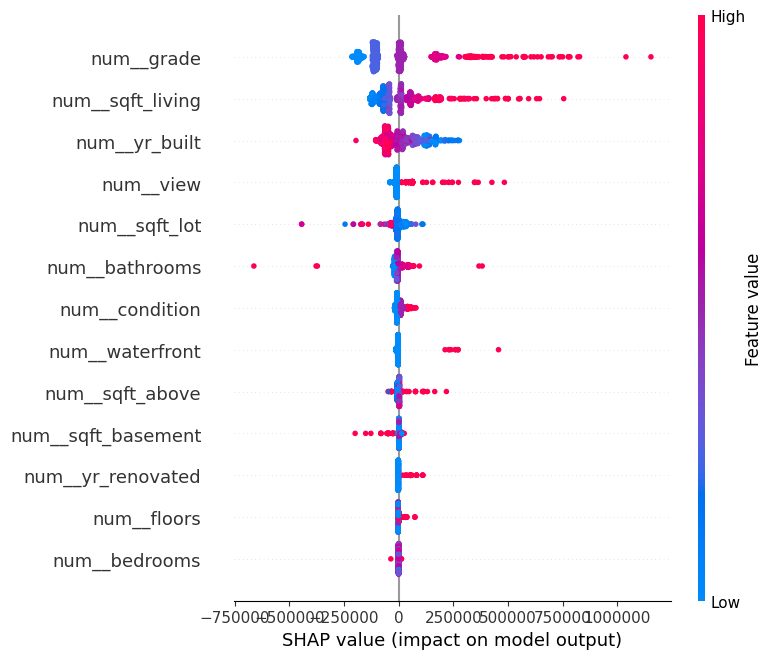

/tmp/ipython-input-1524846585.py:43: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


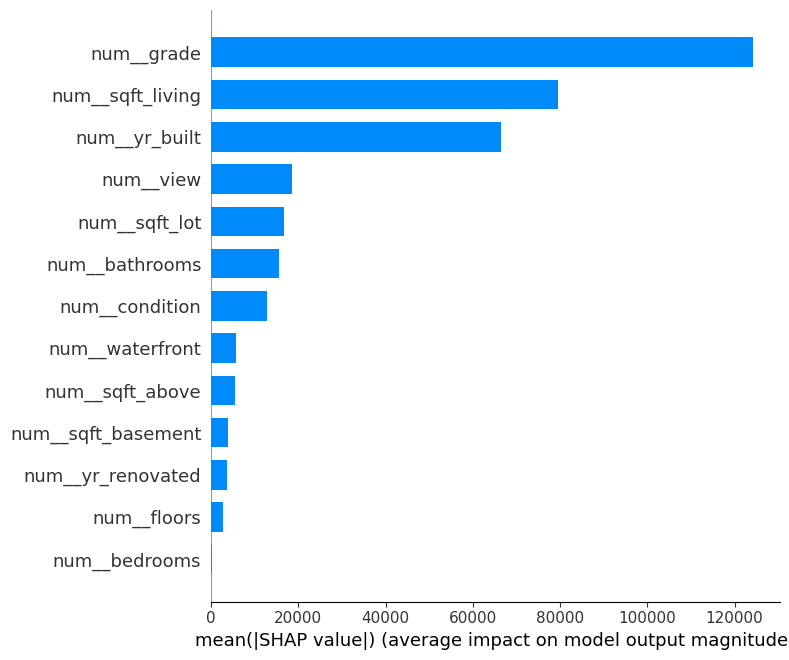

In [ ]:
import numpy as np
import shap
from matplotlib import pyplot as plt

# Get preprocessor + regressor from your fitted GridSearchCV best pipeline
xgb_pre = gs_xgb.best_estimator_.named_steps["preprocessor"]
xgb_reg = gs_xgb.best_estimator_.named_steps["regressor"]

def safe_feature_names(preprocessor):
    try:
        return list(preprocessor.get_feature_names_out())
    except Exception:
        return None

xgb_feature_names = safe_feature_names(xgb_pre)
print("XGB feature names available:", xgb_feature_names is not None)

# Transform ONLY what you already have in your context: X_test
X_test_xgb = xgb_pre.transform(X_test)
print("X_test_xgb shape:", X_test_xgb.shape)

# -------------------------
# XGBoost SHAP (REGRESSION)
# - no class dimension
# - no class slicing
# -------------------------
expl_xgb = shap.TreeExplainer(xgb_reg)
shap_xgb = expl_xgb.shap_values(X_test_xgb)

print("XGB SHAP shape:", np.array(shap_xgb).shape)

# XGB beeswarm
shap.summary_plot(
    shap_xgb,
    X_test_xgb,
    feature_names=xgb_feature_names,
    show=False
)
plt.tight_layout()
plt.show()

# XGB bar (mean |SHAP|)
shap.summary_plot(
    shap_xgb,
    X_test_xgb,
    feature_names=xgb_feature_names,
    plot_type="bar",
    show=False
)
plt.tight_layout()
plt.show()


## 5) SHAP for regression: meaning + global summary plot

### Standard definition (regression)
For a single prediction:
- **baseline (expected value)**: the model’s average prediction on background data
- **SHAP value**: how much one feature pushes the prediction up or down from baseline
- prediction = baseline + sum(SHAP values)

In regression, SHAP values have the **same unit** as the target.

### Known edge cases
- Correlated predictors can “share” importance, so rankings may shift.
- Rare categories can be unstable (few training examples).

<font color='red'><b>Note</b>: Use a sample for speed. The story matters more than computing SHAP on every row.</font>


In [ ]:
import numpy as np

# Mean absolute SHAP per feature (REGRESSION: shap_xgb is 2D [n_samples, n_features])
mean_abs_shap = np.abs(shap_xgb).mean(axis=0)

# Sort feature indices by impact (descending)
order = np.argsort(mean_abs_shap)[::-1]

# Sorted feature names (most impactful first)
# (fall back to generic names if get_feature_names_out() was not available)
if xgb_feature_names is None:
    xgb_feature_names = [f"feature_{i}" for i in range(len(mean_abs_shap))]

xgb_feature_names_sorted = [xgb_feature_names[i] for i in order]

# Optional: preview top features
print("Top SHAP features:")
for name, val in zip(xgb_feature_names_sorted[:10], mean_abs_shap[order][:10]):
    print(f"{name:30s}  mean|SHAP| = {val:.4f}")


Top SHAP features:
num__grade                      mean|SHAP| = 124182.6484
num__sqft_living                mean|SHAP| = 79439.2578
num__yr_built                   mean|SHAP| = 66410.4453
num__view                       mean|SHAP| = 18430.9414
num__sqft_lot                   mean|SHAP| = 16767.3223
num__bathrooms                  mean|SHAP| = 15523.4111
num__condition                  mean|SHAP| = 12882.8652
num__waterfront                 mean|SHAP| = 5777.4258
num__sqft_above                 mean|SHAP| = 5389.0269
num__sqft_basement              mean|SHAP| = 3807.5164


## 6) Local explanation: pick 1 case and explain it

Pick a record that is interesting:
- very high predicted price
- very low predicted price
- large error (y_true far from y_pred)

You will produce a **waterfall** plot for that single case.

<font color='red'><b>Note</b>: Write “In this model…” not “In real life…”. Avoid causality claims.</font>


shap_vals shape: (1000, 13)
baseline (base_value): 547988.4

Chosen feature: num__grade
Row selection mode: max_pos
Selected row index i (within X_test): 358
Feature SHAP at i: 1152876.750000

Top contributors for this case (by |SHAP|):
- num__grade                     SHAP= 1152876.7500 (pushes UP)
- num__sqft_living               SHAP= 754191.6875 (pushes UP)
- num__bathrooms                 SHAP= 381836.6250 (pushes UP)
- num__sqft_above                SHAP= 164790.5312 (pushes UP)
- num__yr_built                  SHAP= 128719.3750 (pushes UP)
- num__yr_renovated              SHAP= 81786.5312 (pushes UP)
- num__sqft_lot                  SHAP= 78162.9688 (pushes UP)
- num__view                      SHAP=-40290.5430 (pushes DOWN)
- num__floors                    SHAP= 36133.8633 (pushes UP)
- num__sqft_basement             SHAP= 5518.3643 (pushes UP)
- num__condition                 SHAP=-3638.0901 (pushes DOWN)
- num__waterfront                SHAP=-3417.3691 (pushes DOWN)


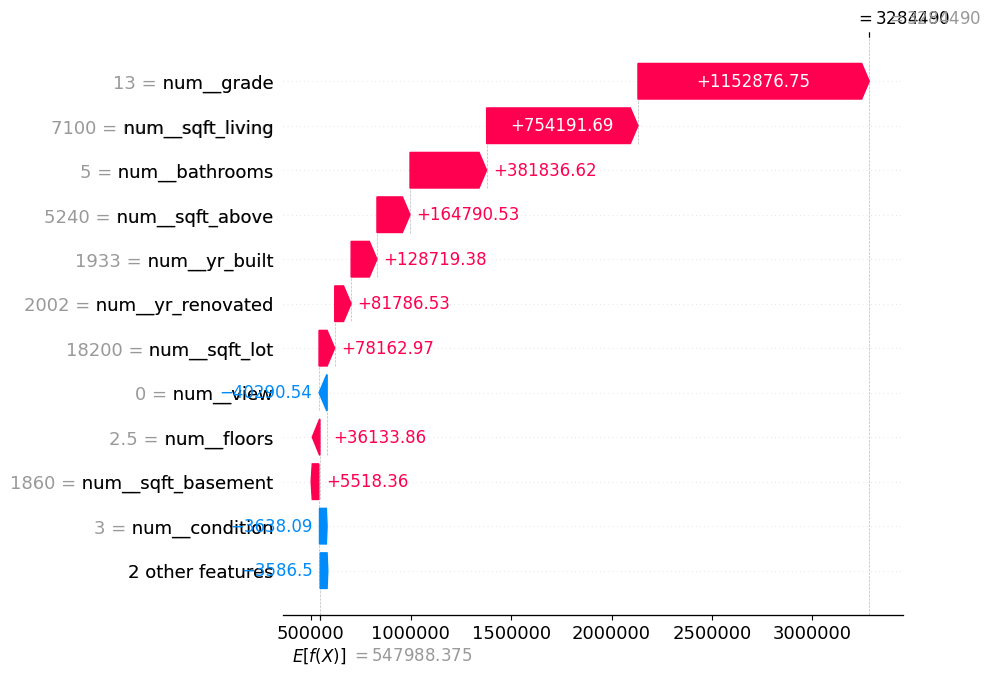

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0) Student choices (REGRESSION: no target_class)
# ------------------------------------------------------------
feature_name = xgb_feature_names_sorted[0]

# Choose how to pick the "most interesting" row for this feature:
# - "max_pos"  : row where SHAP(feature) is most positive (pushes prediction UP most)
# - "max_neg"  : row where SHAP(feature) is most negative (pushes prediction DOWN most)
# - "max_abs"  : row where |SHAP(feature)| is largest (strongest impact either way)
# - "near_zero": row where SHAP(feature) is closest to 0 (feature has least impact)
pick_mode = "max_pos"   # change to: "max_neg", "max_abs", "near_zero"


# ------------------------------------------------------------
# 1) Get SHAP values for regression (2D: n_samples x n_features)
# ------------------------------------------------------------
shap_vals = expl_xgb.shap_values(X_test_xgb)
shap_vals = np.asarray(shap_vals)

base = expl_xgb.expected_value
base_value = base if not isinstance(base, (list, np.ndarray)) else base[0]

print("shap_vals shape:", shap_vals.shape)
print("baseline (base_value):", base_value)


# ------------------------------------------------------------
# 2) Choose row based on pick_mode for the selected feature
# ------------------------------------------------------------
feat_j = xgb_feature_names.index(feature_name)

shap_vals_feat = shap_vals[:, feat_j]

if pick_mode == "max_pos":
    i = int(np.argmax(shap_vals_feat))
elif pick_mode == "max_neg":
    i = int(np.argmin(shap_vals_feat))
elif pick_mode == "max_abs":
    i = int(np.argmax(np.abs(shap_vals_feat)))
elif pick_mode == "near_zero":
    i = int(np.argmin(np.abs(shap_vals_feat)))
else:
    raise ValueError('pick_mode must be one of: "max_pos", "max_neg", "max_abs", "near_zero"')

print(f"\nChosen feature: {feature_name}")
print(f"Row selection mode: {pick_mode}")
print(f"Selected row index i (within X_test): {i}")
print(f"Feature SHAP at i: {shap_vals[i, feat_j]:.6f}")


# ------------------------------------------------------------
# 3) Waterfall for that row
# ------------------------------------------------------------
exp = shap.Explanation(
    values=shap_vals[i],
    base_values=base_value,
    data=X_test_xgb[i],
    feature_names=xgb_feature_names
)

# Top contributors (good for students)
vals = np.asarray(exp.values)
top_idx = np.argsort(np.abs(vals))[::-1][:12]
print("\nTop contributors for this case (by |SHAP|):")
for k in top_idx:
    direction = "pushes UP" if vals[k] > 0 else "pushes DOWN"
    print(f"- {xgb_feature_names[k]:30s} SHAP={vals[k]: .4f} ({direction})")

shap.plots.waterfall(exp, max_display=12)
plt.show()


## 7) Dependence plot: how SHAP changes when a feature changes

You will pick the top 1–2 features from the global summary.
A dependence plot helps you see patterns like:
- roughly linear increase/decrease
- thresholds
- saturation
- interaction hints

<font color='red'><b>Note</b>: If your chosen feature is a one-hot column, interpret it as “present vs not present”.</font>


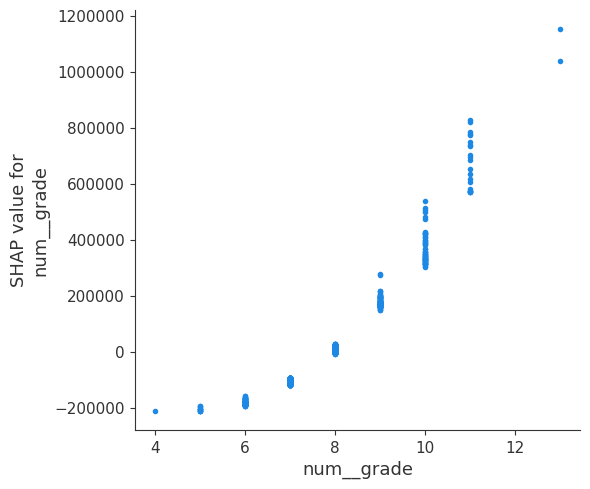

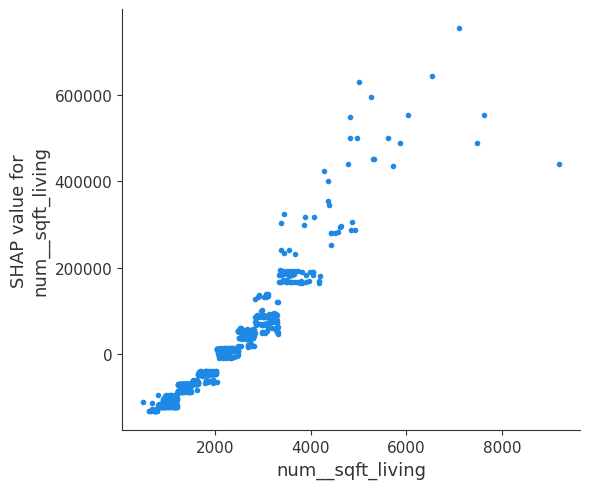

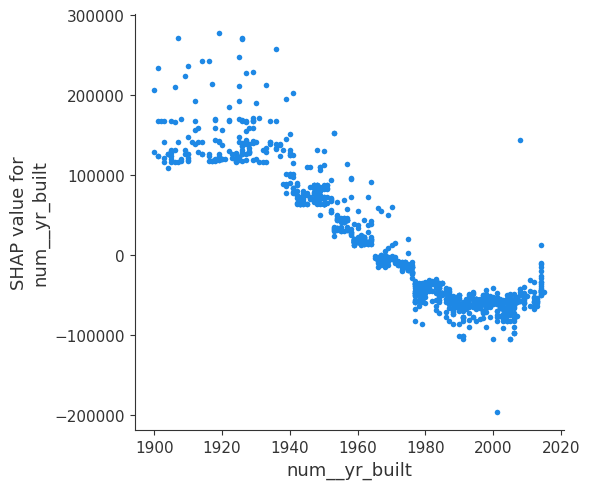

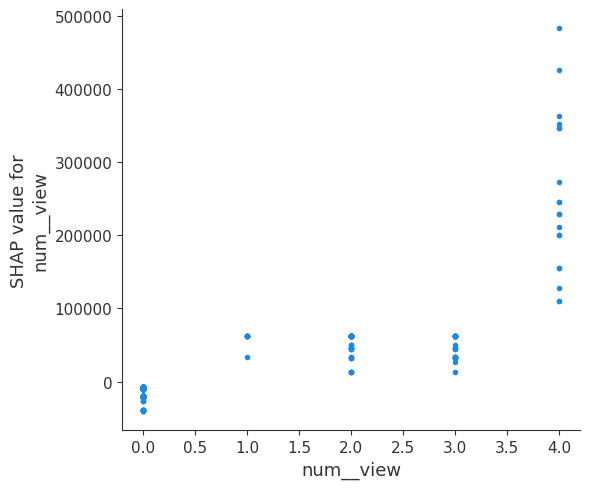

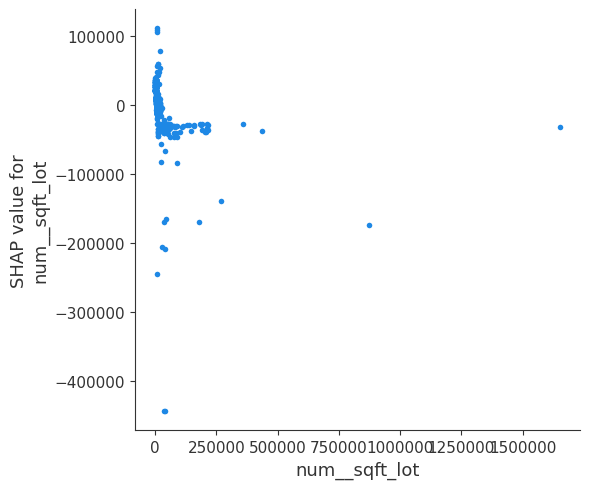

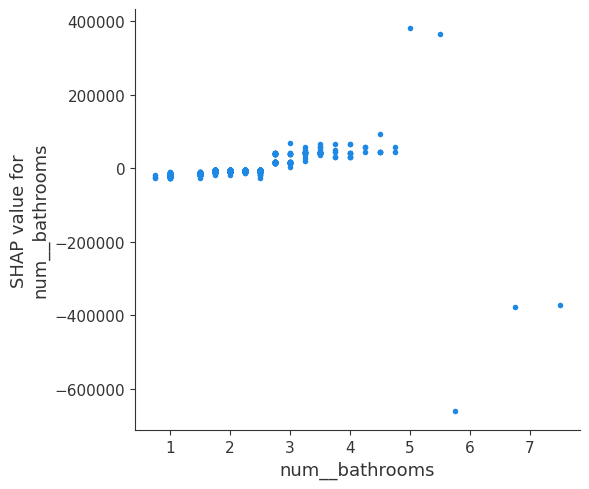

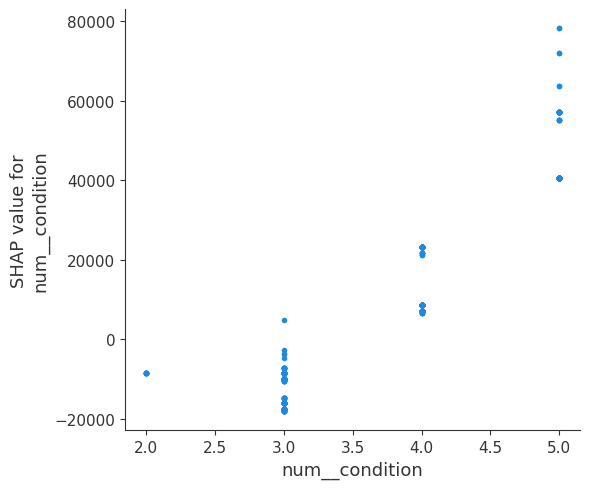

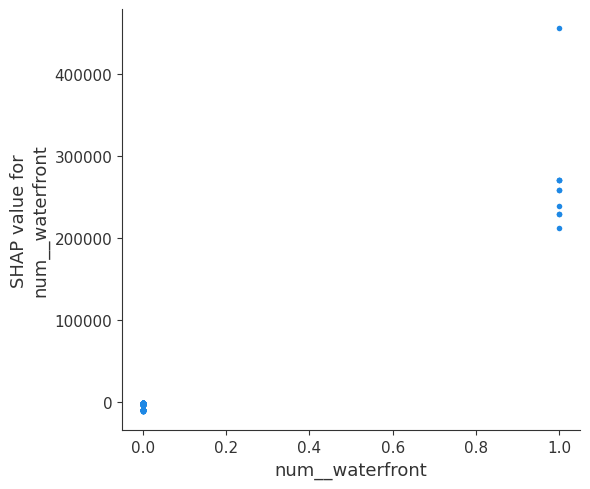

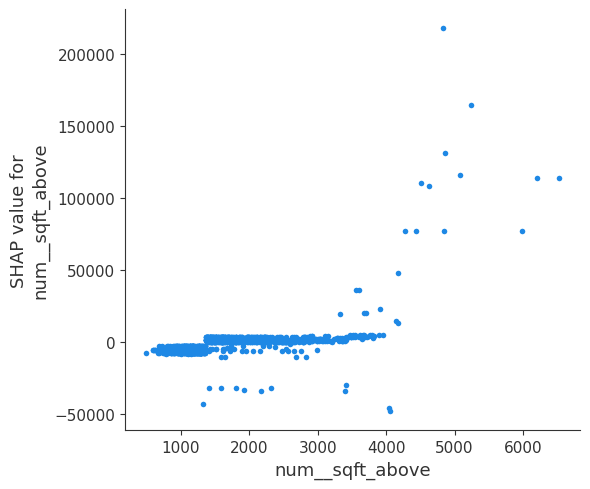

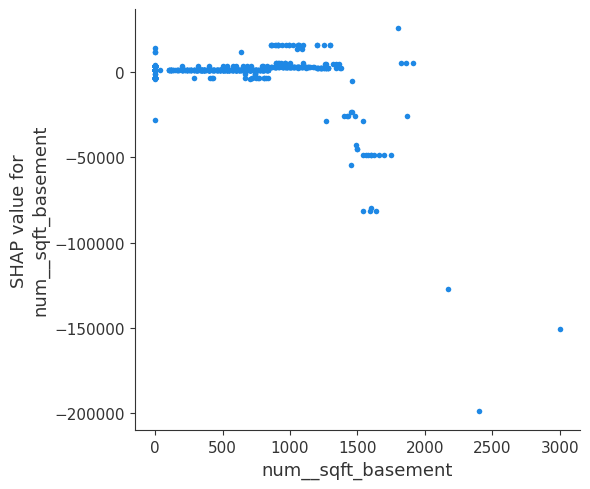

In [ ]:
for feature_name in xgb_feature_names_sorted[:10]:
    shap.dependence_plot(
        feature_name,
        shap_xgb,
        X_test_xgb,
        feature_names=xgb_feature_names,
        interaction_index=None,
        show=False
    )
    plt.tight_layout()
    plt.show()

## 8) What-if checks with persona context (model sensitivity + stakeholder thinking) " The last mile of convincing

### Standard approach (how this widget works)

* Start from **one realistic base case**
* Change **one feature at a time** using the sliders
* Recompute the prediction and observe **how much it moves**
* Repeat for different features to see **which levers matter most**

This tells you **what the model is sensitive to**, not what you should automatically change in real life.

---

### New addition: persona-linked reasoning

In this widget, you do not stop at “the prediction changed”.

You also:

* Select a **target audience (persona)** such as buyer, seller, or risk reviewer
* Interpret the same model output **from that person’s goal and constraints**
* Decide **which features you are allowed to recommend changing**
* Adjust the meaning of the “target” (budget cap, desired minimum, reference value)

This reflects real data-science work, where **the same model is explained differently to different users**.

---

### Important caveats (read before using)

* What-if checks show **model sensitivity**, not cause and effect
* Some features are **not truly controllable** or are linked together
  (for example, year built, renovation year, and condition)
* Persona rules deliberately **block unrealistic or unethical recommendations**

<font color='red'><b>Note</b></font>:
Always propose **plausible scenarios**, explain **why a change makes sense**, and clearly state **what the model cannot justify**.

---


In [ ]:
# ============================================================
# Colab interactive "what-if" sliders + Persona-linked guidance
# Single cell version (run top to bottom)
#
# Assumes you already have:
#   - df (full dataset, used for slider ranges)
#   - X_train, X_test (features, same columns as df except target)
#   - gs_xgb (GridSearchCV) OR a fitted pipeline named pipe
#
# If gs_xgb exists, we use gs_xgb.best_estimator_. Otherwise we use pipe.
# ============================================================

import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output

# ------------------------------------------------------------
# 0) Get the fitted regression pipeline
# ------------------------------------------------------------
try:
    pipe = gs_xgb.best_estimator_
except NameError:
    # If you don't have gs_xgb, ensure you have a fitted 'pipe' already.
    pipe = pipe

def predict_one(raw_row_df: pd.DataFrame) -> float:
    return float(pipe.predict(raw_row_df)[0])

# ------------------------------------------------------------
# 1) Pick a base case (realistic starting point)
#    - choose a row that predicts under 200k if possible
# ------------------------------------------------------------
pred_test = pipe.predict(X_test)
mask_under = pred_test < 200_000

if mask_under.any():
    base_idx = int(np.where(mask_under)[0][0])
else:
    base_idx = 0  # fallback

base_case = X_test.iloc[base_idx].copy()
base_pred = predict_one(base_case.to_frame().T)

print(f"Base row index in X_test: {base_idx}")
print(f"Baseline predicted price: {base_pred:,.0f}")

# ------------------------------------------------------------
# 2) Slider ranges from dataset distribution (robust)
# ------------------------------------------------------------
def qrange(col, qlo=0.01, qhi=0.99):
    s = df[col]
    lo = float(s.quantile(qlo))
    hi = float(s.quantile(qhi))
    if lo == hi:
        lo, hi = float(s.min()), float(s.max())
    return lo, hi

# Students can adjust these as "scenario knobs"
slider_features = [
    "sqft_living",
    "bedrooms",
    "bathrooms",
    "grade",
    "floors",
    "view",
    "condition",
    "yr_renovated",
    "waterfront"
]
slider_features = [c for c in slider_features if c in X_test.columns]

# ------------------------------------------------------------
# 3) Create widgets for sliders + target box
# ------------------------------------------------------------
w = {}

for c in slider_features:
    lo, hi = qrange(c)
    v0 = base_case[c]

    # Binary-like
    if c == "waterfront" and df[c].dropna().isin([0, 1]).all():
        w[c] = widgets.Dropdown(
            options=[0, 1],
            value=int(v0),
            description=c,
            continuous_update=False
        )

    # Integer-like
    elif c in ["bedrooms", "grade", "floors", "view", "condition", "yr_renovated", "yr_built"]:
        lo_i = int(np.floor(lo))
        hi_i = int(np.ceil(hi))
        v_i  = int(v0)
        w[c] = widgets.IntSlider(
            value=v_i, min=lo_i, max=hi_i, step=1,
            description=c, continuous_update=False
        )

    # Float-like
    else:
        step = (hi - lo) / 50 if hi > lo else 1.0
        w[c] = widgets.FloatSlider(
            value=float(v0), min=float(lo), max=float(hi), step=float(step),
            description=c, continuous_update=False, readout_format=".0f"
        )

# Default "target" means different things depending on persona (see below)
goal_box = widgets.IntText(value=200_000, description="Target", disabled=False)

out_main = widgets.Output()
out_persona = widgets.Output()

def current_row_from_widgets(base_row: pd.Series) -> pd.DataFrame:
    row = base_row.copy()
    for c, widget in w.items():
        row[c] = widget.value
    return row.to_frame().T

# ------------------------------------------------------------
# 4) Single-step move evaluator (your original logic)
#    - tries one step down and one step up for each feature
#    - returns best move per feature, sorted by improvement
# ------------------------------------------------------------
def try_single_step_moves(cur_row: pd.Series, target: float) -> list[dict]:
    cur_df = cur_row.to_frame().T
    cur_pred = predict_one(cur_df)
    cur_dist = abs(cur_pred - target)

    suggestions = []

    for c, widget in w.items():
        test_row = cur_row.copy()

        candidates = []

        # Dropdown (binary)
        if isinstance(widget, widgets.Dropdown):
            candidates = [1 - int(widget.value)]

        # IntSlider
        elif isinstance(widget, widgets.IntSlider):
            step = int(widget.step)
            v = int(widget.value)
            candidates = [v - step, v + step]

        # FloatSlider
        elif isinstance(widget, widgets.FloatSlider):
            step = float(widget.step)
            v = float(widget.value)
            candidates = [v - step, v + step]

        # Clip to bounds + unique
        clean_candidates = []
        for v2 in candidates:
            if isinstance(widget, widgets.IntSlider):
                v2 = int(np.clip(v2, widget.min, widget.max))
            elif isinstance(widget, widgets.FloatSlider):
                v2 = float(np.clip(v2, widget.min, widget.max))
            elif isinstance(widget, widgets.Dropdown):
                v2 = int(v2)
            clean_candidates.append(v2)

        clean_candidates = list(dict.fromkeys(clean_candidates))

        best_for_feature = None
        for v2 in clean_candidates:
            test_row[c] = v2
            pred2 = predict_one(test_row.to_frame().T)
            dist2 = abs(pred2 - target)
            improve = cur_dist - dist2

            rec = {
                "feature": c,
                "from": float(widget.value),
                "to": float(v2),
                "pred_now": cur_pred,
                "pred_new": pred2,
                "dist_now": cur_dist,
                "dist_new": dist2,
                "improvement": improve,
                "delta_pred": pred2 - cur_pred
            }

            if (best_for_feature is None) or (rec["improvement"] > best_for_feature["improvement"]):
                best_for_feature = rec

        if best_for_feature is not None:
            suggestions.append(best_for_feature)

    suggestions.sort(key=lambda d: d["improvement"], reverse=True)
    return suggestions

# ------------------------------------------------------------
# 5) Persona selector (ties model actions to target audience)
# ------------------------------------------------------------
personas = {
    "First-time buyer (budget cap)": {
        "role": "Buyer",
        "goal": "Stay under budget while meeting basic needs",
        "pain_point": "Needs a clear trade-off explanation",
        "target_meaning": "Budget cap (want prediction BELOW target)",
        "success_rule": "pred < target",
        "allowed_levers": ["sqft_living", "bedrooms", "bathrooms", "grade", "condition", "view", "waterfront", "yr_renovated"],
        "avoid_levers": ["yr_built"],
        "talk_track": [
            "Use the target as the budget cap.",
            "Explain trade-offs: which changes reduce predicted price most.",
            "Mention uncertainty and outliers, and that this is a model estimate."
        ]
    },
    "Seller (maximise price)": {
        "role": "Seller",
        "goal": "Increase expected price with plausible improvements",
        "pain_point": "Asks what upgrades are worth it",
        "target_meaning": "Desired minimum (want prediction ABOVE target)",
        "success_rule": "pred > target",
        "allowed_levers": ["condition", "grade", "yr_renovated", "bathrooms", "view", "sqft_living"],
        "avoid_levers": ["waterfront", "yr_built"],
        "talk_track": [
            "Use the target as the minimum you want to reach.",
            "Recommend plausible upgrades only and quantify expected lift.",
            "State it is an estimate, not a guarantee."
        ]
    },
    "Mortgage officer (risk control)": {
        "role": "Risk reviewer",
        "goal": "Control lending risk by checking value consistency",
        "pain_point": "Needs defendable reasons",
        "target_meaning": "Independent estimate (want prediction CLOSE to target)",
        "success_rule": "abs(pred-target) small",
        "allowed_levers": ["sqft_living", "grade", "bathrooms", "bedrooms", "view", "waterfront", "condition"],
        "avoid_levers": ["yr_renovated"],
        "talk_track": [
            "Use the target as an independent valuation reference.",
            "Explain top drivers and flag outlier risk.",
            "Avoid weak or noisy fields in the decision note."
        ]
    },
    "City planner (insight only)": {
        "role": "Policy user",
        "goal": "Understand price patterns, not set a price",
        "pain_point": "Needs insight, not a single number",
        "target_meaning": "Reference point for sensitivity (not a decision threshold)",
        "success_rule": "N/A",
        "allowed_levers": ["sqft_living", "grade", "view", "waterfront", "floors", "condition"],
        "avoid_levers": ["bedrooms", "bathrooms"],
        "talk_track": [
            "Do not give buying or selling advice.",
            "Show which features the model reacts to most.",
            "Talk about sensitivity and trade-offs."
        ]
    }
}

persona_dd = widgets.Dropdown(
    options=list(personas.keys()),
    value="First-time buyer (budget cap)",
    description="Persona",
    layout=widgets.Layout(width="420px")
)

mode_dd = widgets.Dropdown(
    options=[("Single best next action", "single_step"), ("Top 3 levers story", "top_3_story")],
    value="single_step",
    description="Style",
    layout=widgets.Layout(width="420px")
)

# ------------------------------------------------------------
# 6) Main update: prediction + distance + generic best next action
# ------------------------------------------------------------
def update_main(*_):
    with out_main:
        clear_output(wait=True)

        target = float(goal_box.value)

        cur_df = current_row_from_widgets(base_case)
        pred = predict_one(cur_df)
        delta_from_base = pred - base_pred

        dist = abs(pred - target)
        direction = "DOWN" if pred > target else "UP"

        print("=== What-if sliders (model sensitivity) ===")
        print(f"Baseline predicted price : {base_pred:,.0f}")
        print(f"Current predicted price  : {pred:,.0f}")
        print(f"Change vs baseline       : {delta_from_base:,.0f}")
        print(f"Target                  : {target:,.0f}")
        print(f"Distance to target       : {dist:,.0f} (need to move {direction} to get closer)")
        print()

        # What changed
        changed = []
        for c, widget in w.items():
            if float(widget.value) != float(base_case[c]):
                changed.append(f"{c}: {base_case[c]} -> {widget.value}")
        if changed:
            print("Changes applied:")
            for t in changed:
                print(" -", t)

        # Generic suggestion (closest to target)
        cur_row = cur_df.iloc[0].copy()
        suggestions = try_single_step_moves(cur_row, target)

        print("\nSuggested next action (generic: reduce distance to target):")
        if len(suggestions) == 0 or suggestions[0]["improvement"] <= 0:
            print("- No single 1-step change improved distance. Try larger steps or change 2 features together.")
        else:
            best = suggestions[0]
            print(
                f"- Adjust {best['feature']} from {best['from']:.0f} to {best['to']:.0f} "
                f"(prediction changes by {best['delta_pred']:,.0f}; distance improves by {best['improvement']:,.0f})."
            )

        print("\nTop 3 levers (generic):")
        for k in suggestions[:3]:
            print(
                f"- {k['feature']}: {k['from']:.0f} -> {k['to']:.0f} | "
                f"pred {k['pred_now']:,.0f} -> {k['pred_new']:,.0f} | "
                f"improve {k['improvement']:,.0f}"
            )

# ------------------------------------------------------------
# 7) Persona update: filters recommendations + changes success rule
# ------------------------------------------------------------
def update_persona(*_):
    with out_persona:
        clear_output(wait=True)

        P = personas[persona_dd.value]
        target = float(goal_box.value)

        cur_df = current_row_from_widgets(base_case)
        pred = float(predict_one(cur_df))

        print("=== Persona-linked recommendation (stakeholder framing) ===")
        print(f"Persona         : {persona_dd.value}")
        print(f"Role            : {P['role']}")
        print(f"Goal            : {P['goal']}")
        print(f"Pain point      : {P['pain_point']}")
        print(f"Target means    : {P['target_meaning']}")
        print()
        print(f"Current predicted price : {pred:,.0f}")
        print(f"Target reference        : {target:,.0f}")

        # Persona-specific success check
        if P["success_rule"] == "pred < target":
            ok = pred < target
            print(f"Meets rule?             : {'YES' if ok else 'NO'} (want BELOW)")
        elif P["success_rule"] == "pred > target":
            ok = pred > target
            print(f"Meets rule?             : {'YES' if ok else 'NO'} (want ABOVE)")
        elif P["success_rule"] == "abs(pred-target) small":
            dist = abs(pred - target)
            print(f"Distance to target      : {dist:,.0f} (want CLOSE)")
        else:
            print("Meets rule?             : Not a threshold task (insight-focused)")

        # Build suggestions using your single-step evaluator
        cur_row = cur_df.iloc[0].copy()
        suggestions = try_single_step_moves(cur_row, target)

        allowed = set([c for c in P["allowed_levers"] if c in w])
        avoid = set([c for c in P["avoid_levers"] if c in w])

        suggestions = [s for s in suggestions if s["feature"] in allowed and s["feature"] not in avoid]

        print("\nAllowed levers (what you can recommend changing):")
        print(", ".join(sorted(list(allowed))) if allowed else "(none)")

        if avoid:
            print("\nAvoid levers (do NOT recommend changing):")
            print(", ".join(sorted(list(avoid))))

        print("\nPersona-safe recommendations:")

        if len(suggestions) == 0:
            print("- No persona-safe single-step move found with current sliders.")
            print("- Try changing 2 levers together, or pick a different base row.")
        else:
            # Re-rank for seller/buyer direction so the suggestion matches the story
            if P["success_rule"] == "pred > target":
                if pred < target:
                    suggestions.sort(key=lambda d: d["delta_pred"], reverse=True)  # biggest lift
                else:
                    suggestions.sort(key=lambda d: abs(d["delta_pred"]))          # keep stable
            elif P["success_rule"] == "pred < target":
                if pred > target:
                    suggestions.sort(key=lambda d: d["delta_pred"])               # most negative first
                else:
                    suggestions.sort(key=lambda d: abs(d["delta_pred"]))          # keep stable

            if mode_dd.value == "single_step":
                best = suggestions[0]
                print(
                    f"- Best next action: adjust {best['feature']} from {best['from']:.0f} to {best['to']:.0f} "
                    f"(prediction changes by {best['delta_pred']:,.0f})."
                )
            else:
                print("- Top 3 levers story:")
                for s in suggestions[:3]:
                    print(
                        f"  • {s['feature']}: {s['from']:.0f} -> {s['to']:.0f} | "
                        f"pred {s['pred_now']:,.0f} -> {s['pred_new']:,.0f} | Δ {s['delta_pred']:,.0f}"
                    )

        print("\nStudent talk track (what you say to this persona):")
        for line in P["talk_track"]:
            print(f"- {line}")

# ------------------------------------------------------------
# 8) One combined callback so both sections refresh together
# ------------------------------------------------------------
def update_all(*_):
    update_main()
    update_persona()

# Attach callbacks
for widget in w.values():
    widget.observe(update_all, names="value")
goal_box.observe(update_all, names="value")
persona_dd.observe(update_all, names="value")
mode_dd.observe(update_all, names="value")

# ------------------------------------------------------------
# 9) Display UI
# ------------------------------------------------------------
# Layout: left = target + persona, middle = sliders, bottom = outputs
controls_top = widgets.HBox([goal_box, persona_dd, mode_dd])

sliders_left = widgets.VBox([w[c] for c in slider_features[:len(slider_features)//2]])
sliders_right = widgets.VBox([w[c] for c in slider_features[len(slider_features)//2:]])
sliders_ui = widgets.HBox([sliders_left, sliders_right])

display(controls_top, sliders_ui, out_main, out_persona)
update_all()


Base row index in X_test: 166
Baseline predicted price: 167,840


Output()

Output()

### How the widget suggests the “next action” (read this before you trust it)

The widget does **not** “know the best renovation” or the real-world cause. It uses a simple search rule:

1. It takes your **current slider settings** as the current scenario.
2. For each slider feature, it tries **two tiny moves**:

   * one step **down**
   * one step **up**
     (for a yes/no feature like `waterfront`, it just tries a **toggle**)
3. For each tried move, it recomputes the prediction and checks which move is “better”, based on the **persona rule**:

   * **Buyer (budget cap):** prefers moves that bring the prediction **closer to or below** the target
   * **Seller (min price):** prefers moves that push the prediction **up** if it is below target
   * **Risk reviewer:** prefers moves that bring prediction **closer** to the reference target
   * **City planner:** shows the biggest movers as **sensitivity levers**, not “do this” advice
4. It then ranks the best move for each feature and shows:

   * **Best next action** (top-ranked move), and sometimes
   * **Top 3 levers** so you can discuss trade-offs

<font color='red'><b>Note</b></font>: This is a **one-step, one-feature-at-a-time** suggestion. It may miss better solutions that require **bigger steps** or **changing two features together**.


## End

### Additional: Using ChatGPT to build a meaningful wrap-up with this widget

This widget is **not** about adding more accuracy to your model.
It is about showing that you can **translate a trained model into decisions and explanations**.

Use ChatGPT as a **thinking and structuring partner**, not as a code generator that you copy blindly.

---

### Step 1: Fix your modelling story first (before prompting)

Before you ask ChatGPT anything, be clear on these points:

* What is your **target variable** and what does it represent in real terms?
* Who is the **user of this model** (buyer, seller, risk reviewer, policy team)?
* What does “good” mean for this user:

  * below a cap?
  * above a minimum?
  * close to a reference value?

Write this in plain English first.
ChatGPT works better when the **story is fixed before the code**.

---

### Step 2: Ask ChatGPT to help you design the *logic*, not just the widget

A useful prompt is:

> “Given my trained regression model and these features, help me design a simple what-if widget that tests model sensitivity and suggests one safe next action for a specific persona.”

What you should expect from ChatGPT:

* A **clear rule** for how “next action” is chosen
* A list of **allowed vs avoided features**
* Explicit **limitations** of the approach

If ChatGPT jumps straight to long code without explaining the logic, stop and ask it to **explain the reasoning first**.

---

### Step 3: Keep the widget simple and defensible

For assessment purposes:

* One base case is enough
* One-feature-at-a-time changes are enough
* One suggested action plus 2 to 3 alternatives are enough

This is a strength, not a weakness.
Simple logic is **easier to explain and defend**.

---

### Step 4: Use ChatGPT to improve your explanation, not your numbers

After the widget works, use ChatGPT to help you write:

* A **persona-specific explanation**, for example:

  * “Why this recommendation makes sense for a first-time buyer”
  * “Why I would *not* recommend changing certain features”
* A **risk statement**, for example:

  * model sensitivity ≠ real-world causation
  * unrealistic combinations were deliberately blocked

Good prompts focus on communication, for example:

> “Rewrite my model recommendation so it is suitable for a non-technical stakeholder, including caveats.”

---

### Step 5: What assessors are really looking for

In your wrap-up, make sure the following are clear:

* You understand **what the model reacts to**
* You understand **who the model is for**
* You can explain **why a recommendation is reasonable**
* You can explain **what the model cannot justify**

The widget is evidence that you can move from:
**model → insight → decision → limitation**

That is the key learning outcome.


<font color='red'><b>Note</b>: Keep claims accurate. “The model learns…” is safer than “The current market / industry is…”.</font>
